In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import time as time
import matplotlib
import matplotlib.pyplot as plt
import math
import cmath
import gmpy2 as gp
from gmpy2 import mpc

#####################################################################################

In [10]:
#Here are some test arrays of level sets that will come in handy:
test = np.array(range(3,91,2))
print(test)

test1 = np.array([3,5,7,9,11,13,15,17,19,23,29,35,41,51,61,71,81,91,101,111])

#Chen-Yang Test set for the figure eight knot complement:
CYtest = [11,13,15,17,19,21,23,25,31,41,51,61,71,81,91,101,111,201,301,401,501,701,1001]

##################################################################################################

[ 3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49
 51 53 55 57 59 61 63 65 67 69 71 73 75 77 79 81 83 85 87 89]


In [34]:
def monodromyRL(word):
    """Returns monodromy of the bundle corresponding to the word 'RL...RL'

    Args:
        word (str): _string of 'RL' repeating

    Returns:
        arr: numpy array corresponding to the 2x2 matrix representing the monodromy of the bundle.
    """
    R = np.array([[1,1],[0,1]])
    L = np.array([[1,0],[1,1]])
    mon = np.array([[1,0],[0,1]])
    i = len(word)//2
    while i > 0:
        mon = mon.dot(np.dot(R,L))
        i = i-1
    return mon

def sf(word):
    return np.linalg.eig(monodromyRL(word))[0][0]

In [7]:
#This function provides a list of the admissible colors for the given level set r:
def colors(r):
    """Colors corresponding to SU(2)-quantum representations

    Args:
        r (int): integer >=3

    Returns:
        list: list of integers from 0 to (r-3)/2
    """
    I = [i for i in range((r-3)//2+1)]
    return I


def A(r):
    """Primitive root of unity for which we are computing all of our invariants, as a function of
    the level set r 

    Args:
        r (int): integer >=3

    Returns:
        complex float: Complex root of unity
    """
    B = cmath.exp(cmath.pi*1j/(r))
    return B
################################################################################################

################################################################
#Supporting functions for quantum integers and factorials
################################################################

def Q(n,A):
    z = (-A)**(n) - (-A)**(-n)
    return z.imag*1j

def Qp(n,A):
    z = (-A)**(n) + (-A)**(-n)
    return z.real
def f1(N,A):
    if N==0:
        return 1
    elif N>0:
        return np.prod([Q(i,A) for i in range(1,N+1)])
    else: 
        return 0
def f1p(N,A):
    if N==0:
        return 2
    elif N>0:
        return np.prod([Qp(i,A) for i in range(1,N+1)])
    else: 
        return 0
def f2(N,A):
    if N==0:
        return 1
    else:
        temp=1
        for i in range(N,0,-2):
            temp=temp*Q(i,A)
            continue
        return temp
def mu(n,A):
    return (-A)**(n*(n+2))
def lamb(n,A):
    return -Q(2*n+2,A)

################################################################################################

################################################################
#Functions used to construct the representations for C_R and C_L
################################################################
def R(c,n,m,A):
    x = f1(m,A)*f2(2*c+2*n+1,A)*f1p(2*c+n+1,A)
    y = f1(n,A)*f2(2*c+2*m+1,A)*f1p(2*c+m+1,A)
    return x/y

def Mminus(N,n,m,A):
    x = Q(m,A)*((-A)**(-2*N+2*m))
    y = Q(n+1,A)
    return x/y
def Mplus(N,n,m,A):
    x = ((-A)**(-2*N+2*m+2))*Q(-2*N+2*m+2,A)*Qp(-2*N+m+1,A)
    y = Q(n+1,A)
    return x/y
def Mmid1(c,N,n,m,A):
    x = (A-A**(-1))*(lamb(c+m,A))**(2)+A*(Q(m+1,A)**(2))*R(c,m+1,m,A)-A**(-1)*(Q(m,A)**2)*R(c,m,m-1,A)-Q(2,A)*lamb(c+n,A)
    y = Q(2,A)*Q(n+1,A)
    return x/y

def Mmid(c,N,n,m,A):
    x = (A-A**(-1))*(Qp(2*N-2*m-1,A))**(2)+A*(Q(m+1,A)**(2))*R(c,m+1,m,A)-A**(-1)*(Q(m,A)**2)*R(c,m,m-1,A)+Q(2,A)*Qp(2*N-2*n-1,A)
    y = Q(2,A)*Q(n+1,A)
    return x/y

def makeM(N,c,n,A):
    bigM = np.zeros(shape=(N,N),dtype=complex)
    bigM[0,0] = Mmid(c,N,n,0,A)
    bigM[0,1] = Mplus(N,n,0,A)
    bigM[N-1,N-2] = Mminus(N,n,N-1,A)
    bigM[N-1,N-1] = Mmid(c,N,n,N-1,A)
    for m in range(1,N-1):
        bigM[m,m] = Mmid(c,N,n,m,A)
        bigM[m,m-1] = Mminus(N,n,m,A)
        bigM[m,m+1] = Mplus(N,n,m,A)
    return bigM

################################################################################################

################################################################
#Build libraries for R and L representations
################################################################

def makeRepR(N,c,A):
    S = np.zeros(shape=(N,N),dtype = complex)
    S[0,0] = 1
    for n in range(1,N):
        M = makeM(N,c,n-1,A)
        S[:,n] = M.dot(S[:,n-1])
    return S

def genRLn(n):
    x = ''
    for i in range(n):
        x = x+ 'RL'
    return x

In [11]:
def libR(array):
    lib = {}
    #np.empty(dtype = object)
    for r in array:
        I = colors(r)
        repsr = [makeRepR((r-1)//2-c,c,A(r)) for c in I]
        lib[r] = repsr
    return lib

time_start = time.process_time()

Rlib = libR(test)

time_elapsed = (time.process_time() - time_start)
print('Time to build R Library: %s seconds' % time_elapsed)

#Once we have the R rep library, we can construct the corresponding library of L reps using these two functions:

def makeRepL(N,r,c,A):
    repR = Rlib[r][c]
    #S = (b_{n,m})
    S = np.linalg.inv(np.array([[repR[m,n]/R(c,n,m,A) for m in range(N)] for n in range(N)]))
    return S

def libL(array):
    lib = {}
    for r in array:
        I = colors(r)
        repsr = [makeRepL((r-1)//2-c,r,c,A(r)) for c in I]
        lib[r] = repsr
    return lib

time_start = time.process_time()

Llib = libL(test)

time_elapsed = (time.process_time() - time_start)
print('Time to build L Library: %s seconds' % time_elapsed)

################################################################################################

#Define representations of C_R and C_L:

def genRep(r,c,string):
    #r >= 3 is odd TV parameter
    #c is color from list of colors, N = (r-1)/2 - c
    #k is choice of primitive 2r root of unity 
    #string is the string of L's and R's 
    N = (r-1)//2-c
    if 'R' in string:
        repR = Rlib[r][c]
    if 'L' in string:
        repL = Llib[r][c]
    rho = np.zeros(shape=(N,N), dtype=complex)
    first = string[0]
    if first == 'L':
        rho = repL
    else: 
        rho = repR
    for char in string[1:]:
        if char == 'L':
            rho = rho.dot(repL)
        else:
            rho = rho.dot(repR)
    return rho

################################################################################################






################################################################
#Computing the Turaev-Viro
################################################################

def TV(r,string):
    I = colors(r)
    traces = [abs(np.trace(genRep(r,c,string)))**2 for c in I]
    TV = sum(traces)
    return TV

#This function computes the logarithm of TV_r, as the Volume Conjecture requires
def QV(r,string):
    return ((2*np.pi)/(r-2))*np.log(TV(r,string))

################################################################################################

################################################################
#Given a list of level sets (subset of the representations library created above) and a list of monodromies 
#(as strings in R,L), this function constructs a library of QV_r values keyed by the string representing the monodromy
################################

def QVLib(array,strings):
    lib = {}
    time_start = time.process_time()
    for stg in strings:
        QVallr = [[r,QV(r,stg)] for r in array]
        lib[stg] = QVallr
    time_elapsed = (time.process_time() - time_start)
    print('Time to compute QV Library: %s seconds' % time_elapsed)
    print(lib)


################################################################################################

QVLib(test,['RL'])

Time to build R Library: 133.515625 seconds
Time to build L Library: 111.4375 seconds
Time to compute QV Library: 0.03125 seconds
{'RL': [[3, 0.0], [5, 2.6932471303224785], [7, 2.4540538901661475], [9, 2.471813475962565], [11, 2.4066064718040256], [13, 2.3775476430702693], [15, 2.3482597089093264], [17, 2.319069508960746], [19, 2.2995342041619997], [21, 2.282265410270453], [23, 2.26834340161997], [25, 2.2563395126909627], [27, 2.245758288636151], [29, 2.2365241931970345], [31, 2.228243278701593], [33, 2.220793492682338], [35, 2.214021154482635], [37, 2.20782193816543], [39, 2.202121985341774], [41, 2.196851943971879], [43, 2.1919605647990603], [45, 2.187403492874009], [47, 2.1831440157887556], [49, 2.1791513020766557], [51, 2.175398668168265], [53, 2.1718632806830684], [55, 2.1685252420180294], [57, 2.1653671843755506], [59, 2.1623738403580735], [61, 2.1595327121662264], [63, 2.1568370639812695], [65, 2.154486868316161], [67, 2.1523233121777507], [69, 2.1513026878916834], [71, 2.213889

In [24]:
def QVvals(array,string):
    x = np.zeros(shape = (len(array),))
    y = np.zeros(shape = (len(array),))
    i=0
    for r in array:
        x[i] = r
        y[i] = QV(r,string)
        print((r,QV(r,string)))
        i=i+1
    return x,y

def K(n):
    return n

def Zn(word):
    n = len(word)//2
    return QV(K(n), word)**(1/float(K(n)))

def Z(word,r):
    n = len(word)//2
    val = QV(r, word)
    return val**(1/float(n))

def mfdsodd(arr):
    m = []
    for word in arr:
        if len(word)//2 %2==1:
            m.append(word)
    return m

(3, 0.0)
(5, 2.6932471303224785)
(7, 2.4540538901661475)
(9, 2.471813475962565)
(11, 2.4066064718040256)
(13, 2.3775476430702693)
(15, 2.3482597089093264)
(17, 2.319069508960746)
(19, 2.2995342041619997)
(21, 2.282265410270453)
(23, 2.26834340161997)
(25, 2.2563395126909627)
(27, 2.245758288636151)
(29, 2.2365241931970345)
(31, 2.228243278701593)
(33, 2.220793492682338)
(35, 2.214021154482635)
(37, 2.20782193816543)
(39, 2.202121985341774)
(41, 2.196851943971879)
(43, 2.1919605647990603)
(45, 2.187403492874009)
(47, 2.1831440157887556)
(49, 2.1791513020766557)
(51, 2.175398668168265)
(53, 2.1718632806830684)
(55, 2.1685252420180294)
(57, 2.1653671843755506)
(59, 2.1623738403580735)
(61, 2.1595327121662264)
(63, 2.1568370639812695)
(65, 2.154486868316161)
(67, 2.1523233121777507)
(69, 2.1513026878916834)


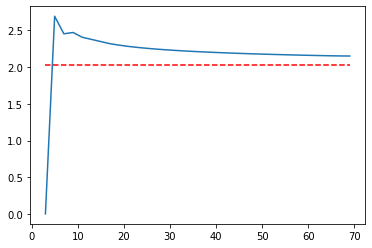

In [16]:
x,y = QVvals(test[test<71],'RL')
vol = np.array([2.029883128 for i in range(len(x))])
plt.plot(x,y)
plt.plot(x,vol,'r--')
plt.show()

In [27]:
mfds = [genRLn(n) for n in range(1,50)]
mfdslite = mfdsodd(mfds)

For r=3, slope = 0.0 and r_value = 0.0
For r=5, slope = -1.0150610510858576e-17 and r_value = -1.2813518903939587e-16
For r=7, slope = 1.2309549717574535 and r_value = 0.9999486566597173
For r=9, slope = 1.2777010569154004 and r_value = 0.9999552262396726
For r=11, slope = 1.4735887485176067 and r_value = 0.9999803910374014
For r=13, slope = 1.5482675217544477 and r_value = 0.9999859999323398
For r=15, slope = 1.6203374860761552 and r_value = 0.9999902250250935
For r=17, slope = 1.6688827700942672 and r_value = 0.9999927203523252
For r=19, slope = 1.708659642670897 and r_value = 0.9999943320191862
For r=21, slope = 1.7399897918991152 and r_value = 0.9999954677300749
For r=23, slope = 1.7658835528299193 and r_value = 0.9999962886978455
For r=25, slope = 1.7874508708316275 and r_value = 0.9999969083865723
For r=27, slope = 1.8057587457302935 and r_value = 0.9999973888697281
For r=29, slope = 1.821474881143047 and r_value = 0.9999977674103635
For r=31, slope = 1.8351221586378057 and r_val

C:\Users\mreclyde\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: overflow encountered in double_scalars


For r=51, slope = nan and r_value = nan
For r=53, slope = nan and r_value = nan
For r=55, slope = nan and r_value = nan
For r=57, slope = nan and r_value = nan
For r=59, slope = nan and r_value = nan
For r=61, slope = nan and r_value = nan
For r=63, slope = nan and r_value = nan
For r=65, slope = nan and r_value = nan
For r=67, slope = nan and r_value = nan
For r=69, slope = nan and r_value = nan


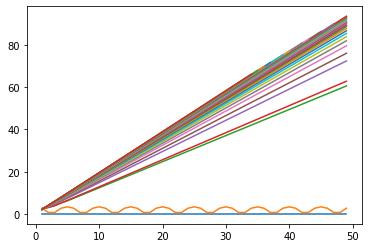

In [28]:
x = range(1,len(mfds)+1)
for r in test[test <71]:
    y = [QV(r,word) for word in mfds]
    plt.plot(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    print("For r=%s, slope = %s and r_value = %s" %(r,slope,r_value))
plt.show()

C:\Users\mreclyde\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
C:\Users\mreclyde\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


(1, inf)
(3, 0.0)
(5, 1.2751068188785486)
(7, 1.3612448736570022)
(9, 1.3122523513544229)
(11, 1.288538199300282)
(13, 1.2600277425686675)
(15, 1.2372400875322633)
(17, 1.2176563763713804)
(19, 1.2011596570778114)
(21, 1.187034410365687)
(23, 1.1748526821425649)
(25, 1.1642407837047464)
(27, 1.1549188500161127)
(29, 1.1466649331270002)
(31, 1.1393048692490613)
(33, 1.1326996496209363)
(35, 1.1267374860059536)
(37, 1.1213275017630748)
(39, 1.1163951509630057)
(41, 1.1118787352629247)
(43, 1.107726771268142)
(45, 1.103895969228688)
(47, 1.1003496699967372)
(49, 1.0970566239116852)


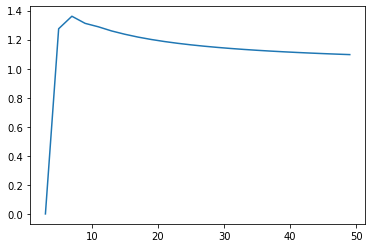

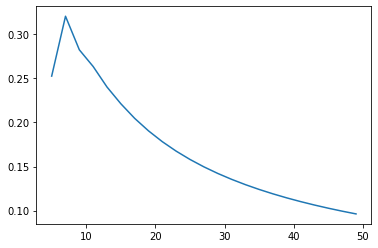

In [37]:
xmfdslite = [len(word)//2 for word in mfdslite]

y = [Zn(word) for word in mfdslite]
power = [np.log(y[i])/np.log(sf('RL')) for i in range(len(y))]

for i in range(len(y)):
    print((xmfdslite[i],y[i]))

plt.plot(xmfdslite,y)
plt.show()
plt.close()

plt.plot(xmfdslite, power)
plt.show()

In [88]:
def AllStrings(n, arr, i):  
  
    if i == n: 
        printTheArray(arr, n)  
        return
      
    # First assign "0" at ith position  
    # and try for all other permutations  
    # for remaining positions  
    arr[i] = 0
    generateAllBinaryStrings(n, arr, i + 1)  
  
    # And then assign "1" at ith position  
    # and try for all other permutations  
    # for remaining positions  
    arr[i] = 1
    generateAllBinaryStrings(n, arr, i + 1)